<a href="https://colab.research.google.com/github/andrewrocke/MSc-code/blob/main/simpleRFwithDatanosave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
tensofflowJs!pip list | grep tensorflow



tensorflow                         2.18.0
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.11.0
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.1
tensorflow-probability             0.24.0
tensorflowjs                       4.22.0


In [ ]:
!pip list | grep tensorflow



tensorflow                         2.18.0
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.11.0
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.1
tensorflow-probability             0.24.0
tensorflowjs                       4.22.0


In [ ]:
!pip list | grep tensorflow



tensorflow                         2.18.0
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.11.0
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.1
tensorflow-probability             0.24.0
tensorflowjs                       4.22.0


In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
from urllib.parse import unquote_to_bytes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt # Import matplotlib
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint




ds = pd.read_csv("output_left_NST.csv")
print("total dataframe :",ds.shape)
print(list(ds))
print(ds.head())
#X=ds['sAddress','rAddress']
#y= ds['IT_B_Label']
mask = np.random.rand(len(ds)) < 0.8
train_ds = ds[mask]
test_ds = ds[~mask]
#print("train_ds",train_ds.head())
#print("test_ds",test_ds.head())

tf_train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds, label="NST_B_Label")
tf_serving_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds, label="NST_B_Label")


#for features, label in tf_train_dataset:
  #print("Features:",features)
  #print("label:", label)
#data = ds.values
model = tfdf.keras.RandomForestModel(num_trees=100,  max_depth=50, verbose=3)
start_time = time.time()
model.fit(tf_train_dataset)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

print("++++++++++++++++++++++++++++++++Summary+++++++++++++++++++++++")
print(model.summary())

model.compile(metrics=["accuracy"])
evaluation = model.evaluate(tf_serving_dataset, return_dict=True)
print("++++++++++++++++++++++++++++++++Evaluation+++++++++++++++++++++++")
print(evaluation)
#for name, value in evaluation.items():
#  print(f"{name}: {value:.4f}")

# Predict on the test set
start_time = time.time()

y_pred_probs = model.predict(tf_serving_dataset)

end_time = time.time()

prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} seconds")

#y_pred = np.argmax(y_pred_probs, axis=1) # Get predicted class labels
y_pred = (y_pred_probs > 0.5).astype(int)

ones_in_column = train_ds['NST_B_Label'].eq(1).sum()
print(f"Number of 1s in the 'NST_B_Label train' column: {ones_in_column}")
zeros_in_column = train_ds['NST_B_Label'].eq(0).sum()
print(f"Number of 0s in the 'NST_B_Label train' column: {zeros_in_column}")
ones_in_test_column = test_ds['NST_B_Label'].eq(1).sum()
print(f"Number of 1s in the 'NST_B_Label test' column: {ones_in_test_column}")
zeros_in_test_column = test_ds['NST_B_Label'].eq(0).sum()
print(f"Number of 0s in the 'NST_B_Label test' column: {zeros_in_test_column}")

# Extract true labels from the tf_serving_dataset
y_true = np.concatenate([y for x, y in tf_serving_dataset], axis=0)

count_ones_y_true = np.sum(y_true == 1)
print(f"Number of 1s in y_true: {count_ones_y_true}")

count_zeros_y_true = np.sum(y_true == 0)
print(f"Number of 0s in y_true: {count_zeros_y_true}")


count_ones_y_pred = np.sum(y_pred == 1)
print(f"Number of 1s in y_pred: {count_ones_y_pred}")

count_zeros_y_pred = np.sum(y_pred == 0)
print(f"Number of 0s in y_pred: {count_zeros_y_pred}")


accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate recall
recall = recall_score(y_true, y_pred)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

#export_archive = tf.keras.export.ExportArchive()
#export_archive.track(model)
#export_archive.add_endpoint(
#    name='serve',
#    fn=model.call,
#    input_signature=[tf.TensorSpec(shape=(1, maxlen), dtype=tf.float32)],
#)
#export_archive.write_out('model')

#converter = tf.lite.TFLiteConverter.from_saved_model('model')

#rf_model = converter.convert()

#with open('rf.model', 'wb') as f:
#    f.write(rf_model)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true))) # Assuming y_true has all possible class labels
plt.xticks(tick_marks, np.unique(y_true), rotation=45)
plt.yticks(tick_marks, np.unique(y_true))

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



total dataframe : (8533, 61)
['sAddress', 'rAddress', 'sMACs', 'rMACs', 'sIPs', 'rIPs', 'protocol', 'startDate', 'endDate', 'start', 'end', 'startOffset', 'endOffset', 'duration', 'sPackets', 'rPackets', 'sBytesSum', 'rBytesSum', 'sBytesMax', 'rBytesMax', 'sBytesMin', 'rBytesMin', 'sBytesAvg', 'rBytesAvg', 'sLoad', 'rLoad', 'sPayloadSum', 'rPayloadSum', 'sPayloadMax', 'rPayloadMax', 'sPayloadMin', 'rPayloadMin', 'sPayloadAvg', 'rPayloadAvg', 'sInterPacketAvg', 'rInterPacketAvg', 'sttl', 'rttl', 'sAckRate', 'rAckRate', 'sUrgRate', 'rUrgRate', 'sFinRate', 'rFinRate', 'sPshRate', 'rPshRate', 'sSynRate', 'rSynRate', 'sRstRate', 'rRstRate', 'sWinTCP', 'rWinTCP', 'sFragmentRate', 'rFragmentRate', 'sAckDelayMax', 'rAckDelayMax', 'sAckDelayMin', 'rAckDelayMin', 'sAckDelayAvg', 'rAckDelayAvg', 'NST_B_Label']
            sAddress           rAddress              sMACs              rMACs  \
0  b8:27:eb:15:88:9c  ff:ff:ff:ff:ff:ff  b8:27:eb:15:88:9c  ff:ff:ff:ff:ff:ff   
1  b8:27:eb:15:88:9c  ff:ff

Training dataset read in 0:00:04.723321. Found 6827 examples.
Training model...


I0000 00:00:1740677713.485665   38879 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740677713.485848   38879 kernel.cc:783] Collect training examples
I0000 00:00:1740677713.485900   38879 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740677713.486721   38879 kernel.cc:401] Number of batches: 7
I0000 00:00:1740677713.486742   38879 kernel.cc:402] Number of examples: 6827
I0000 00:00:1740677713.502406   38879 data_spec_inference.cc:354] 5693 item(s) have been pruned (i.e. they are considered out of dictionary) for the column endDate (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1740

Model trained in 0:00:07.144146
Compiling model...
Model compiled.


Training time: 13.778944253921509 seconds
++++++++++++++++++++++++++++++++Summary+++++++++++++++++++++++
Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (60):
	duration
	end
	endDate
	endOffset
	protocol
	rAckDelayAvg
	rAckDelayMax
	rAckDelayMin
	rAckRate
	rAddress
	rBytesAvg
	rBytesMax
	rBytesMin
	rBytesSum
	rFinRate
	rFragmentRate
	rIPs
	rInterPacketAvg
	rLoad
	rMACs
	rPackets
	rPayloadAvg
	rPayloadMax
	rPayloadMin
	rPayloadSum
	rPshRate
	rRstRate
	rSynRate
	rUrgRate
	rWinTCP
	rttl
	sAckDelayAvg
	sAckDelayMax
	sAckDelayMin
	sAckRate
	sAddress
	sBytesAvg
	sBytesMax
	sBytesMin
	sBytesSum
	sFinRate
	sFragmentRate
	sIPs
	sInterPacketAvg
	sLo

2/2 [==============================] - 1s 129ms/step - loss: 0.0000e+00 - accuracy: 0.9666
++++++++++++++++++++++++++++++++Evaluation+++++++++++++++++++++++
{'loss': 0.0, 'accuracy': 0.9665884971618652}
2/2 [==============================] - 1s 45ms/step
Prediction time: 0.6616718769073486 seconds
Number of 1s in the 'NST_B_Label train' column: 3589
Number of 0s in the 'NST_B_Label train' column: 3238
Number of 1s in the 'NST_B_Label test' column: 919
Number of 0s in the 'NST_B_Label test' column: 787
Number of 1s in y_true: 919
Number of 0s in y_true: 787
Number of 1s in y_pred: 894
Number of 0s in y_pred: 812
Accuracy: 0.9666
Precision: 0.9821
Recall: 0.9554
F1-score: 0.9686
AUC: 0.9952


In [ ]:
!pip list | grep tensorflow



tensorflow                         2.18.0
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.11.0
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.1
tensorflow-probability             0.24.0
tensorflowjs                       4.22.0


In [ ]:
!python --version

Python 3.10.12


In [ ]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
pip show version tf_keras

Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: tensorflow
Required-by: tensorflow-hub, tensorflow_decision_forests, tensorflowjs


In [ ]:
pip show versions tensorflowjs


Name: tensorflowjs
Version: 4.22.0
Summary: 
Home-page: https://js.tensorflow.org/
Author: Google LLC
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: flax, importlib_resources, jax, jaxlib, packaging, six, tensorflow, tensorflow-decision-forests, tensorflow-hub, tf-keras
Required-by: 


total dataframe : (8533, 52)
Use 2 thread(s) for training
Use /tmp/tmpb1s6vw9s as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'start': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'end': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'startOffset': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'endOffset': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'duration': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'sPackets': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'rPackets': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'sBytesSum': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'rBytesSum': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'sBytesMax': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'rBytesMax': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'sBytesMin': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, 'rBytesMin': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, '

I0000 00:00:1740668181.448606   38879 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740668181.448749   38879 kernel.cc:783] Collect training examples
I0000 00:00:1740668181.448782   38879 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740668181.450071   38879 kernel.cc:401] Number of batches: 7
I0000 00:00:1740668181.450094   38879 kernel.cc:402] Number of examples: 6800
I0000 00:00:1740668181.456879   38879 kernel.cc:802] Training dataset:
Number of records: 6800
Number of columns: 52

Number of columns by type:
	NUMERICAL: 51 (98.0769%)
	CATEGORICAL: 1 (1.92308%)

Columns:

NUMERICAL: 51 (98.0769%)
	1: "duration" NUMERICAL m

Model trained in 0:00:03.438616
Compiling model...
Model compiled.
Training time: 15.782042503356934 seconds
++++++++++++++++++++++++++++++++Summary+++++++++++++++++++++++
Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (51):
	duration
	end
	endOffset
	rAckDelayAvg
	rAckDelayMax
	rAckDelayMin
	rAckRate
	rBytesAvg
	rBytesMax
	rBytesMin
	rBytesSum
	rFinRate
	rFragmentRate
	rInterPacketAvg
	rLoad
	rPackets
	rPayloadAvg
	rPayloadMax
	rPayloadMin
	rPayloadSum
	rPshRate
	rRstRate
	rSynRate
	rUrgRate
	rWinTCP
	rttl
	sAckDelayAvg
	sAckDelayMax
	sAckDelayMin
	sAckRate
	sBytesAvg
	sBytesMax
	sBytesMin
	sBytesSum
	sFinRate
	sFragmentRate
	sInterPacketA

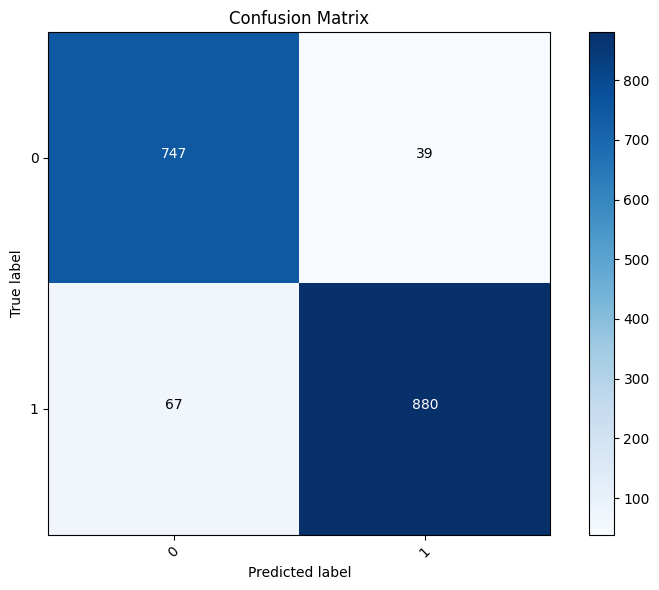

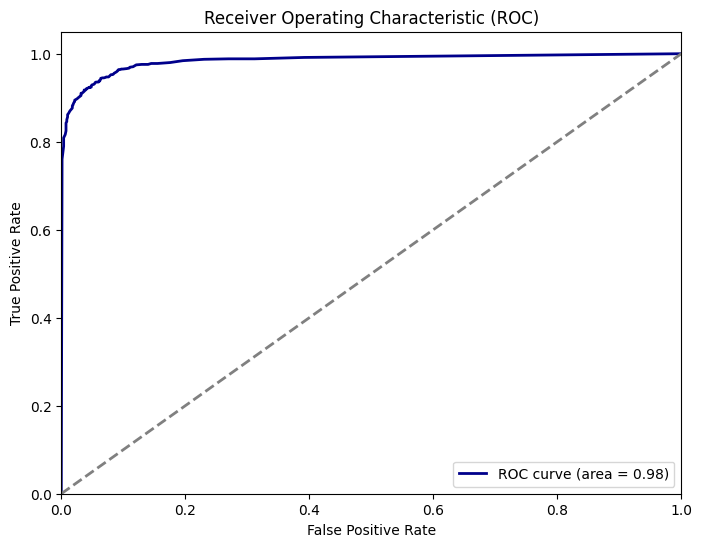

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
from urllib.parse import unquote_to_bytes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt # Import matplotlib
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint




ds = pd.read_csv("output_left_singlelabel_add_del_NST.csv")
print("total dataframe :",ds.shape)
#print(list(ds))
#print(ds.head())
#X=ds['sAddress','rAddress']
#y= ds['IT_B_Label']
mask = np.random.rand(len(ds)) < 0.8
train_ds = ds[mask]
test_ds = ds[~mask]
#print("train_ds",train_ds.head())
#print("test_ds",test_ds.head())

tf_train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds, label="NST_B_Label")
tf_serving_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds, label="NST_B_Label")


#for features, label in tf_train_dataset:
  #print("Features:",features)
  #print("label:", label)
#data = ds.values
model = tfdf.keras.RandomForestModel(num_trees=100,  max_depth=50, verbose=3)
start_time = time.time()
model.fit(tf_train_dataset)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

print("++++++++++++++++++++++++++++++++Summary+++++++++++++++++++++++")
print(model.summary())

model.compile(metrics=["accuracy"])
evaluation = model.evaluate(tf_serving_dataset, return_dict=True)
print("++++++++++++++++++++++++++++++++Evaluation+++++++++++++++++++++++")
print(evaluation)
#for name, value in evaluation.items():
#  print(f"{name}: {value:.4f}")

# Predict on the test set
start_time = time.time()

y_pred_probs = model.predict(tf_serving_dataset)

end_time = time.time()

prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time} seconds")

#y_pred = np.argmax(y_pred_probs, axis=1) # Get predicted class labels
y_pred = (y_pred_probs > 0.5).astype(int)

ones_in_column = train_ds['NST_B_Label'].eq(1).sum()
print(f"Number of 1s in the 'NST_B_Label train' column: {ones_in_column}")
zeros_in_column = train_ds['NST_B_Label'].eq(0).sum()
print(f"Number of 0s in the 'NST_B_Label train' column: {zeros_in_column}")
ones_in_test_column = test_ds['NST_B_Label'].eq(1).sum()
print(f"Number of 1s in the 'NST_B_Label test' column: {ones_in_test_column}")
zeros_in_test_column = test_ds['NST_B_Label'].eq(0).sum()
print(f"Number of 0s in the 'NST_B_Label test' column: {zeros_in_test_column}")

# Extract true labels from the tf_serving_dataset
y_true = np.concatenate([y for x, y in tf_serving_dataset], axis=0)

count_ones_y_true = np.sum(y_true == 1)
print(f"Number of 1s in y_true: {count_ones_y_true}")

count_zeros_y_true = np.sum(y_true == 0)
print(f"Number of 0s in y_true: {count_zeros_y_true}")


count_ones_y_pred = np.sum(y_pred == 1)
print(f"Number of 1s in y_pred: {count_ones_y_pred}")

count_zeros_y_pred = np.sum(y_pred == 0)
print(f"Number of 0s in y_pred: {count_zeros_y_pred}")


accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred)

# Calculate recall
recall = recall_score(y_true, y_pred)

# Calculate F1-score
f1 = f1_score(y_true, y_pred)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

#export_archive = tf.keras.export.ExportArchive()
#export_archive.track(model)
#export_archive.add_endpoint(
#    name='serve',
#    fn=model.call,
#    input_signature=[tf.TensorSpec(shape=(1, 1024), dtype=tf.float32)],
#)
#export_archive.write_out('model')

#converter = tf.lite.TFLiteConverter.from_saved_model('model')

#rf_model = converter.convert()

#with open('rf.model', 'wb') as f:
#    f.write(rf_model)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true))) # Assuming y_true has all possible class labels
plt.xticks(tick_marks, np.unique(y_true), rotation=45)
plt.yticks(tick_marks, np.unique(y_true))

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations to the confusion matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

